# What drives the price of a car?

![](images/kurt.jpeg)

**OVERVIEW**

In this application, you will explore a dataset from kaggle. The original dataset contained information on 3 million used cars. The provided dataset contains information on 426K cars to ensure speed of processing.  Your goal is to understand what factors make a car more or less expensive.  As a result of your analysis, you should provide clear recommendations to your client -- a used car dealership -- as to what consumers value in a used car.

### CRISP-DM Framework

<center>
    <img src = images/crisp.png width = 50%/>
</center>


To frame the task, throughout our practical applications we will refer back to a standard process in industry for data projects called CRISP-DM.  This process provides a framework for working through a data problem.  Your first step in this application will be to read through a brief overview of CRISP-DM [here](https://mo-pcco.s3.us-east-1.amazonaws.com/BH-PCMLAI/module_11/readings_starter.zip).  After reading the overview, answer the questions below.

### Business Understanding

From a business perspective, we are tasked with identifying key drivers for used car prices.  In the CRISP-DM overview, we are asked to convert this business framing to a data problem definition.  Using a few sentences, reframe the task as a data task with the appropriate technical vocabulary. 

**Note:** All Student's notes are decorated with 📌 emoji.

#### 📌 Translate Business Objectives to Data Analysis Objectives

As a data analyst to find answers for the above business objectives (to identify key features driving the Vehicle Price) I need to:
* Fit and measure performance of a few models to predict the target car price; Tune the models's hyper-parameters; Pick the most optimal model.
* Finally analyze coefficients of the most optimal model for the selected car features to provide answers to the business objectives.

### Data Understanding

After considering the business understanding, we want to get familiar with our data.  Write down some steps that you would take to get to know the dataset and identify any quality issues within.  Take time to get to know the dataset and explore what information it contains and how this could be used to inform your business understanding.

#### 📌 Load Necessary Libraries

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.feature_selection import SequentialFeatureSelector, SelectFromModel
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.compose import make_column_transformer, make_column_selector, ColumnTransformer
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import set_config
set_config(display = "diagram")

# Configure Pandas to display float types in more readable format using a custom callback.
pd.set_option('display.float_format', lambda input_float: '%3f' % input_float)

#### 📌 Load the Data and Describe it

In [2]:
df = pd.read_csv('data/vehicles.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426880 entries, 0 to 426879
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            426880 non-null  int64  
 1   region        426880 non-null  object 
 2   price         426880 non-null  int64  
 3   year          425675 non-null  float64
 4   manufacturer  409234 non-null  object 
 5   model         421603 non-null  object 
 6   condition     252776 non-null  object 
 7   cylinders     249202 non-null  object 
 8   fuel          423867 non-null  object 
 9   odometer      422480 non-null  float64
 10  title_status  418638 non-null  object 
 11  transmission  424324 non-null  object 
 12  VIN           265838 non-null  object 
 13  drive         296313 non-null  object 
 14  size          120519 non-null  object 
 15  type          334022 non-null  object 
 16  paint_color   296677 non-null  object 
 17  state         426880 non-null  object 
dtypes: f

In [3]:
df.isna().mean().sort_values()

id             0.000000
price          0.000000
state          0.000000
region         0.000000
year           0.002823
transmission   0.005988
fuel           0.007058
odometer       0.010307
model          0.012362
title_status   0.019308
manufacturer   0.041337
type           0.217527
paint_color    0.305011
drive          0.305863
VIN            0.377254
condition      0.407852
cylinders      0.416225
size           0.717675
dtype: float64

📌 Insight:
* There is quite a bit of missing values. This will need to be addressed by dropping an offending feature or by data imputation.
* Columns VIN or ID do not influence Vehicle Price and can be dropped altogether.
* Column `year` is encoded as `float` type which does not make sense as it is a scalar. This feature could be also converted to a more meaningful `age` feature -> `age = <current year> - <car model year>`. 

In [4]:
df.sample(10, random_state = 44)

,id,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,state
16314,7311624350,tucson,0,2020.000000,dodge,challenger,NaN,NaN,gas,11251.000000,clean,automatic,2C3CDZBT1LH196306,NaN,NaN,NaN,NaN,az
26545,7313968849,fresno / madera,21995,2011.000000,ford,f-250,excellent,NaN,diesel,176000.000000,clean,automatic,NaN,NaN,NaN,NaN,NaN,ca
361837,7313097680,tri-cities,6500,2013.000000,hyundai,veloster,good,4 cylinders,gas,131000.000000,clean,automatic,NaN,fwd,compact,hatchback,black,tn
48536,7316774532,reno / tahoe,0,2006.000000,ford,f-150 fx4 fx4 4dr supercab,NaN,8 cylinders,gas,289162.000000,clean,automatic,1FTPX14576FA16983,4wd,NaN,truck,NaN,ca
367989,7308254751,corpus christi,20507,2014.000000,audi,q5,NaN,6 cylinders,diesel,76479.000000,clean,automatic,WA1CMAFP5EA078135,4wd,mid-size,SUV,grey,tx
285829,7310589234,new hampshire,99,2018.000000,hyundai,elantra,NaN,NaN,gas,27180.000000,clean,automatic,5NPD84LF8JH389623,fwd,full-size,sedan,grey,nh
232570,7314438891,charlotte,10000,1950.000000,gmc,NaN,NaN,6 cylinders,gas,20000.000000,clean,manual,NaN,rwd,NaN,pickup,NaN,nc
180380,7308039947,maine,15995,2009.000000,toyota,tacoma,excellent,NaN,gas,152000.000000,clean,automatic,3TMLU42N69M028994,4wd,NaN,pickup,brown,me
219267,7316627934,columbia / jeff city,11500,1929.000000,NaN,Model A,good,4 cylinders,gas,10000.000000,clean,manual,NaN,rwd,mid-size,pickup,yellow,mo
135098,7303259715,lewiston / clarkston,3500,2006.000000,NaN,Milan,good,4 cylinders,gas,120000.000000,clean,manual,NaN,fwd,NaN,sedan,black,id


In [5]:
df.describe()

,id,price,year,odometer
count,426880.000000,426880.000000,425675.000000,422480.000000
mean,7311486634.224333,75199.033187,2011.235191,98043.331443
std,4473170.412559,12182282.173604,9.452120,213881.500798
min,7207408119.000000,0.000000,1900.000000,0.000000
25%,7308143339.250000,5900.000000,2008.000000,37704.000000
50%,7312620821.000000,13950.000000,2013.000000,85548.000000
75%,7315253543.500000,26485.750000,2017.000000,133542.500000
max,7317101084.000000,3736928711.000000,2022.000000,10000000.000000


📌 Insight:
* There are some really bogus entires.
* Minimum `price` is 0; `year` - 1900; `odometer` - 0.0
* Maximum `price` is 3,736,928,711; `odometer` - 10,000,000.

##### 📌 Analyze the Price ($) data 

Vehicle Price is the univariate we need to predict. It is important to examine its distribution. The closer it is to normal distribution the better will be our models.

Number of records with Price value <= 0:  32895
Number of records with Price value > 100,000:  655


/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


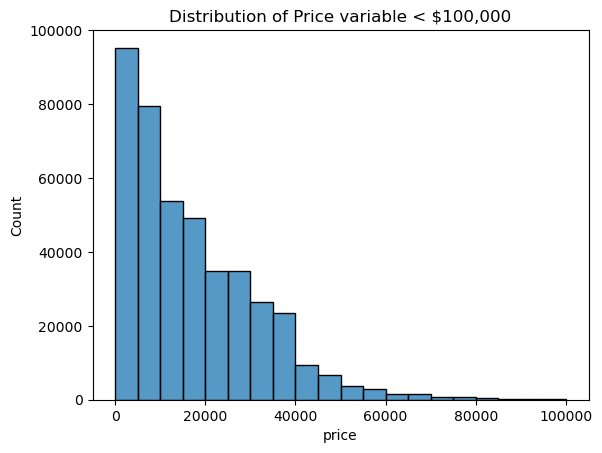

In [6]:
print('Number of records with Price value <= 0: ', df.query('price <= 0')['price'].count())
print('Number of records with Price value > 100,000: ', df.query('price > 100_000')['price'].count())
plot = sns.histplot(data = df.query('price < 100_000')['price'], bins = 20)
plot.set(title = 'Distribution of Price variable < $100,000')
plot.get_figure().savefig('images/price-dist-before.png')

Clearly Vehicle Price variable is not normally distributed. There is a lof of outliers. Primarily 0-values but there are also some very expensive exotic cars. This will need to be addressed in the data preparation phase. 

##### 📌 Other Features - Production Year

[Text(0.5, 1.0, 'Distribution of vehicle production year')]

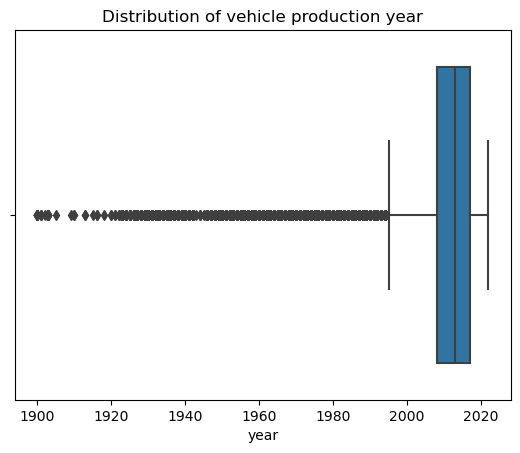

In [7]:
sns.boxplot(data = df, x = 'year').set(title = 'Distribution of vehicle production year')

We will need to address cars with bogus `year` entries. 1900 is not the only one bogus value as found earlier. I think we should drop cars manufactured before year 2000. Antics market is a separate and speculative domain on its own and outside of our business objective. 

In addition we can convert `year` to something like `age` to better express the negative impact vehicle's `age` has on its `price`. 

[Text(0.5, 1.0, 'Distribution of vehicle odometer')]

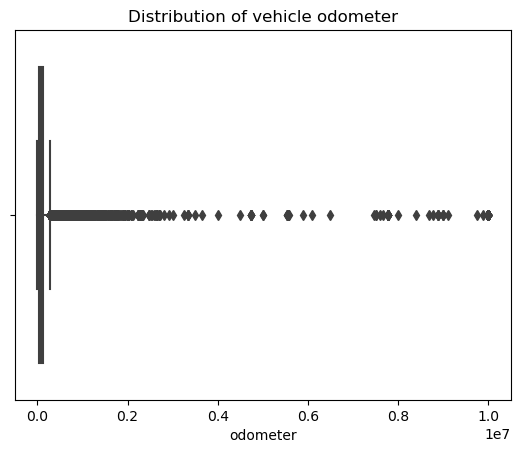

In [8]:
sns.boxplot(data = df, x = 'odometer').set(title = 'Distribution of vehicle odometer')

Similarly to `year`, we will need to discard entries with bogus `odometer` entries. Probably over 200,000 miles is a reasonable filter cut off value.

##### 📌 Other Features - Number of Cylinders

In [9]:
df['cylinders'].value_counts()

cylinders
6 cylinders     94169
4 cylinders     77642
8 cylinders     72062
5 cylinders      1712
10 cylinders     1455
other            1298
3 cylinders       655
12 cylinders      209
Name: count, dtype: int64

We can convert cylinders to numerical type. Then decide if we still need it. It seems like an important driver of a car price (characterizes engine performance) but also there's a lot of missing values. 42% of data is missing.

##### 📌 Other Features - Vehicle Size

In [10]:
df['size'].value_counts()

size
full-size      63465
mid-size       34476
compact        19384
sub-compact     3194
Name: count, dtype: int64

Car size might be another important feature but 72% of data is missing. 

##### 📌 Other Features - Title Status

In [11]:
df['title_status'].value_counts()

title_status
clean         405117
rebuilt         7219
salvage         3868
lien            1422
missing          814
parts only       198
Name: count, dtype: int64

Only 2% if data is missing. We could use Ordinal Encoding. Perhaps remove `missing` and `parts only` vehicles or only focus on `clean` titles too.

##### 📌 Other Features - Transmission Type

In [12]:
df['transmission'].value_counts()

transmission
automatic    336524
other         62682
manual        25118
Name: count, dtype: int64

Only 0.6% of data is missing but I don't think this data is relevant in the US. In Europe, for example, Automatic transmission cars are unpopular.

##### 📌 Other Features - Drive Train Type

In [13]:
df['drive'].value_counts()

drive
4wd    131904
fwd    105517
rwd     58892
Name: count, dtype: int64

31% of data missing. Seems irrelevant.

##### 📌 Other Features - Brand

In [14]:
df['manufacturer'].value_counts()

manufacturer
ford               70985
chevrolet          55064
toyota             34202
honda              21269
nissan             19067
jeep               19014
ram                18342
gmc                16785
bmw                14699
dodge              13707
mercedes-benz      11817
hyundai            10338
subaru              9495
volkswagen          9345
kia                 8457
lexus               8200
audi                7573
cadillac            6953
chrysler            6031
acura               5978
buick               5501
mazda               5427
infiniti            4802
lincoln             4220
volvo               3374
mitsubishi          3292
mini                2376
pontiac             2288
rover               2113
jaguar              1946
porsche             1384
mercury             1184
saturn              1090
alfa-romeo           897
tesla                868
fiat                 792
harley-davidson      153
ferrari               95
datsun                63
aston-martin

We have only %4 of `manufacturer` data missing and brand matters in sales. Let's try to use that data if possible. With this many unique values it will increase the complexity of the model however. Perhaps `Ordinal Encoder` should be used.

##### 📌 Other Features - Condition

In [15]:
df['condition'].value_counts()

condition
good         121456
excellent    101467
like new      21178
fair           6769
new            1305
salvage         601
Name: count, dtype: int64

40% of data is missing. However, `condition` seems essential in Vehicle Price evaluation.

##### 📌 Other Features - State and Region

In [16]:
df.groupby('state')['price'].mean().sort_values(ascending = False)
df.groupby('region')['price'].mean().sort_values(ascending = False)

region
frederick             4914334.204861
delaware              3205055.885142
humboldt county       2902729.974026
modesto               1401324.300034
knoxville             1369993.301122
                           ...      
sioux city               9649.819338
southeast IA             9624.102857
klamath falls            9550.169096
west virginia (old)      9423.750000
siskiyou county          8293.855422
Name: price, Length: 404, dtype: float64

It looks like in Delaware there's a lot of expensive car sales?!? But generally region and state information should not affect car price.

##### 📌 Correlation Report

<Axes: >

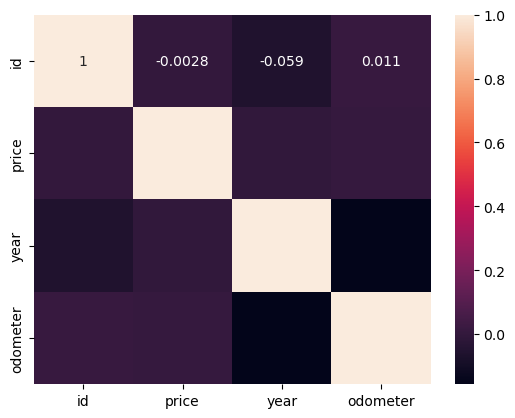

In [17]:
corr = df.corr(numeric_only = True)
sns.heatmap(data = corr, annot = True)

Nothing interesting here. Correlation analysis will make more sense after the data cleanup.

##### 📌 Duplicates

In [18]:
df.duplicated().sum()

0

### Data Preparation

After our initial exploration and fine tuning of the business understanding, it is time to construct our final dataset prior to modeling.  Here, we want to make sure to handle any integrity issues and cleaning, the engineering of new features, any transformations that we believe should happen (scaling, logarithms, normalization, etc.), and general preparation for modeling with `sklearn`. 

In [19]:
# Make a "deep" copy from the original DataFrame. Simple assignment does only a "shallow" copy.
veh = df.copy()

#### 📌 Handle Outliers

In [20]:
# Remove cars older than year 2000. Also add new column 'age'. Since max 'year' is 2022 we will bias the 'age' at 2022.
veh = veh.query('year >= 2000')
veh['age'] = 2022 - veh['year'].dropna().astype(np.int32)
# Finally, remove year column since we have age.
veh.drop(columns = ['year'], inplace = True)

In [21]:
# Remove cars with mileage over 200k miles.
veh = veh.query('odometer <= 200_000')

In [22]:
# Keep entries where price is in range: ~500 - ~300,000
# Also convert price to log() to get normal distribution.
veh = veh.query('(price >= 1_000) and (price <= 200_000)')
veh['price_log'] = np.log(veh['price'])

#### 📌 Drop Columns, NaNs and Duplicates

In [23]:
# Drop columns with not much relevant data.
veh.drop(columns = ['id', 'VIN', 'fuel', 'model'], inplace = True)

# Drop columns with majority of missing data.
veh.drop(columns = ['size', 'cylinders', 'condition', 'drive', 'paint_color', 'type'], inplace = True)

# Drop categorical columns that would just increase number of features. We can come back to them later. 
veh.drop(columns = ['transmission', 'state', 'region'], inplace = True)

In [24]:
# Drop all remaining NaNs.
veh.dropna(inplace = True)

# Drop leftover duplicates.
veh.drop_duplicates(keep = False, inplace = True)

#### 📌 Final Check

In [25]:
veh.info()
veh.describe()

<class 'pandas.core.frame.DataFrame'>
Index: 130077 entries, 31 to 426819
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   price         130077 non-null  int64  
 1   manufacturer  130077 non-null  object 
 2   odometer      130077 non-null  float64
 3   title_status  130077 non-null  object 
 4   age           130077 non-null  int32  
 5   price_log     130077 non-null  float64
dtypes: float64(2), int32(1), int64(1), object(2)
memory usage: 6.5+ MB


,price,odometer,age,price_log
count,130077.000000,130077.000000,130077.000000,130077.000000
mean,15555.010586,99115.114993,10.313714,9.343660
std,13148.800355,52137.377906,5.069825,0.807656
min,1000.000000,0.000000,0.000000,6.907755
25%,6500.000000,57850.000000,6.000000,8.779557
50%,11900.000000,100740.000000,10.000000,9.384294
75%,20000.000000,140000.000000,14.000000,9.903488
max,195000.000000,200000.000000,22.000000,12.180755


In [26]:
print(df.shape)
print(df.duplicated().sum())
print(veh.shape)
print(veh.duplicated().sum())

(426880, 18)
0
(130077, 6)
0


We have ~130,000 rows left for training and validation.

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


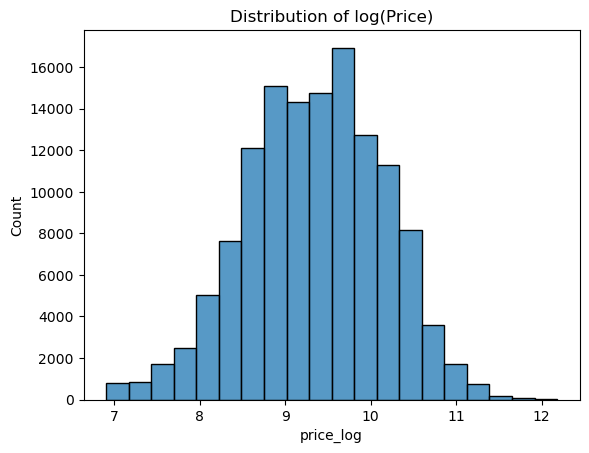

In [27]:
plot = sns.histplot(data = veh['price_log'], bins = 20)
plot.set(title = 'Distribution of log(Price)')
plot.get_figure().savefig('images/price-dist-after.png')

After logarithmic transformation of the `price` column we see normal distribution pattern emerging.

#### 📌 Final Correlation Report

<Axes: >

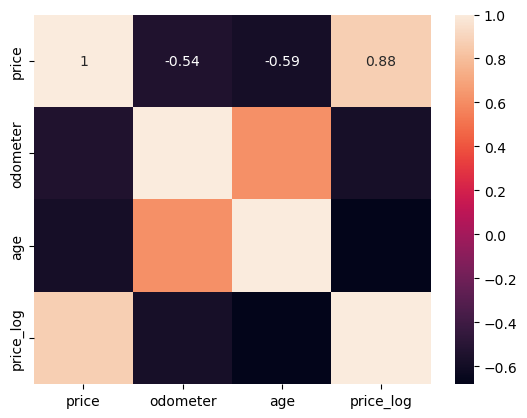

In [28]:
corr = veh.corr(numeric_only = True)
sns.heatmap(data = corr, annot = True)

After data cleaning and data conversion we can see a very strong negative corelation between car's age and odometer reading against its price.

#### 📌 Transformations

Let's split the data for training and validation.

In [29]:
X = veh.drop(columns = ['price', 'price_log'])
y = veh['price_log']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 44)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(104061, 4)
(26016, 4)
(104061,)
(26016,)


Configure a Column Transformer. It will be shared with various models below.

In [30]:
# Note that "handle_unknown = 'use_encoded_value'" in 
# OrdinalEncoder constructor is required 
# when the Column Transformer is used in a pipeline 
# with CV validation or Grid Search. Some categories 
# and their encodings might be missing between training
# and validation subsets causing runtime errors.
column_transformer = ColumnTransformer([
    ('numeric', PolynomialFeatures(degree = 3, include_bias = False), ['odometer', 'age']),
    ('ordinal_encoder', OrdinalEncoder(handle_unknown = 'use_encoded_value', unknown_value = -1), ['manufacturer', 'title_status']), 
])
column_transformer.fit(X_train, y_train)

ColumnTransformer(transformers=[('numeric',
                                 PolynomialFeatures(degree=3,
                                                    include_bias=False),
                                 ['odometer', 'age']),
                                ('ordinal_encoder',
                                 OrdinalEncoder(handle_unknown='use_encoded_value',
                                                unknown_value=-1),
                                 ['manufacturer', 'title_status'])])

Check how feature names will look like after transformation.

In [31]:
column_transformer.get_feature_names_out()

array(['numeric__odometer', 'numeric__age', 'numeric__odometer^2',
       'numeric__odometer age', 'numeric__age^2', 'numeric__odometer^3',
       'numeric__odometer^2 age', 'numeric__odometer age^2',
       'numeric__age^3', 'ordinal_encoder__manufacturer',
       'ordinal_encoder__title_status'], dtype=object)

### Modeling

With your (almost?) final dataset in hand, it is now time to build some models.  Here, you should build a number of different regression models with the price as the target.  In building your models, you should explore different parameters and be sure to cross-validate your findings.

#### 📌 Common Code Area

In [32]:
# Helper function printing score and MSE.
# Note: It references global variables X_train, y_train and X_test, y_test.
def print_score_and_mse(pipeline):
    print('Training Score: ', (pipeline.score(X_train, y_train)))
    print('Test Score: ', (pipeline.score(X_test, y_test)))
    print('Training MSE: ', mean_squared_error(y_train, pipeline.predict(X_train)))
    print('Test MSE: ', mean_squared_error(y_test, pipeline.predict(X_test)))

#### 📌 Linear Regression Model

For the Linear Regression model let's build a Pipeline using the configured Column Transformer above. The numerical values need to be scaled so that we can compare coefficients.

In [33]:
pipe_lr = Pipeline([
    ('column_transformer', column_transformer),
    ('scaler', StandardScaler()),
    ('lin_regression', LinearRegression()),
])
pipe_lr.fit(X_train, y_train)

Pipeline(steps=[('column_transformer',
                 ColumnTransformer(transformers=[('numeric',
                                                  PolynomialFeatures(degree=3,
                                                                     include_bias=False),
                                                  ['odometer', 'age']),
                                                 ('ordinal_encoder',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  ['manufacturer',
                                                   'title_status'])])),
                ('scaler', StandardScaler()),
                ('lin_regression', LinearRegression())])

In [34]:
print_score_and_mse(pipeline = pipe_lr)

Training Score:  0.5243459183300764
Test Score:  0.5276312133964518
Training MSE:  0.31085495344402847
Test MSE:  0.3057831977579553


#### 📌 Ridge Model with Default Alpha

In [35]:
pipe_ridge_def_alpha = Pipeline([
    ('column_transformer', column_transformer),
    ('scaler', StandardScaler()),
    ('ridge', Ridge()),
])
pipe_ridge_def_alpha.fit(X_train, y_train)

Pipeline(steps=[('column_transformer',
                 ColumnTransformer(transformers=[('numeric',
                                                  PolynomialFeatures(degree=3,
                                                                     include_bias=False),
                                                  ['odometer', 'age']),
                                                 ('ordinal_encoder',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  ['manufacturer',
                                                   'title_status'])])),
                ('scaler', StandardScaler()), ('ridge', Ridge())])

In [36]:
print_score_and_mse(pipeline = pipe_ridge_def_alpha)

Training Score:  0.5243456114237555
Test Score:  0.527627986236505
Training MSE:  0.3108551540169948
Test MSE:  0.30578528682758954


#### 📌 Ridge Model with Optimal Alpha

In [37]:
params_dict = {'ridge__alpha': 10**np.linspace(-4, 4, 100)}

pipe_ridge_optimal_alpha = Pipeline([
    ('column_transformer', column_transformer),
    ('scaler', StandardScaler()),
    ('ridge', Ridge()),
])
grid_search = GridSearchCV(
    pipe_ridge_optimal_alpha, 
    param_grid = params_dict,
    scoring = 'neg_mean_squared_error'
)
grid_search.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('column_transformer',
                                        ColumnTransformer(transformers=[('numeric',
                                                                         PolynomialFeatures(degree=3,
                                                                                            include_bias=False),
                                                                         ['odometer',
                                                                          'age']),
                                                                        ('ordinal_encoder',
                                                                         OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                        unknown_value=-1),
                                                                         ['manufacturer',
                                                                          'title_status'])])),
                                       ('scaler', StandardScaler()),
                                       ('ridge', Ridge())]),
             param_g...
       1.38488637e+02, 1.66810054e+02, 2.00923300e+02, 2.42012826e+02,
       2.91505306e+02, 3.51119173e+02, 4.22924287e+02, 5.09413801e+02,
       6.13590727e+02, 7.39072203e+02, 8.90215085e+02, 1.07226722e+03,
       1.29154967e+03, 1.55567614e+03, 1.87381742e+03, 2.25701972e+03,
       2.71858824e+03, 3.27454916e+03, 3.94420606e+03, 4.75081016e+03,
       5.72236766e+03, 6.89261210e+03, 8.30217568e+03, 1.00000000e+04])},
             scoring='neg_mean_squared_error')

Optimal Alpha identified with Grid Search.

In [38]:
grid_search.best_params_

{'ridge__alpha': 1.0974987654930568}

In [39]:
print_score_and_mse(pipeline = grid_search.best_estimator_)

Training Score:  0.524345549409271
Test Score:  0.527627642624527
Training MSE:  0.3108551945454175
Test MSE:  0.30578550926135817


#### 📌 Linear Regression with SFS selection based on Lasso

SFS is configured to pick 4 features.

In [40]:
sfs_lasso_pipeline = Pipeline([
    ('column_transformer', column_transformer),
    ('scaler', StandardScaler()),
    ('sfs', SequentialFeatureSelector(estimator = Lasso(), n_features_to_select = 4)),
    ('lin_regression', LinearRegression()),
])
sfs_lasso_pipeline.fit(X_train, y_train)

Pipeline(steps=[('column_transformer',
                 ColumnTransformer(transformers=[('numeric',
                                                  PolynomialFeatures(degree=3,
                                                                     include_bias=False),
                                                  ['odometer', 'age']),
                                                 ('ordinal_encoder',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  ['manufacturer',
                                                   'title_status'])])),
                ('scaler', StandardScaler()),
                ('sfs',
                 SequentialFeatureSelector(estimator=Lasso(),
                                           n_features_to_select=4)),
                ('lin_regression', LinearRegression())])

In [41]:
print_score_and_mse(pipeline = sfs_lasso_pipeline)

Training Score:  0.5042197780215694
Test Score:  0.5094452719046768
Training MSE:  0.3240080212925042
Test MSE:  0.31755568463961137


Get the names of SFS-selected features.

In [42]:
sfs_lasso_pipeline[:-1].get_feature_names_out()

array(['numeric__odometer', 'numeric__age', 'numeric__odometer^2',
       'numeric__odometer age'], dtype=object)

### Evaluation

With some modeling accomplished, we aim to reflect on what we identify as a high quality model and what we are able to learn from this.  We should review our business objective and explore how well we can provide meaningful insight on drivers of used car prices.  Your goal now is to distill your findings and determine whether the earlier phases need revisitation and adjustment or if you have information of value to bring back to your client.

#### 📌 Model Test Results Comparison
Here are the test scores of various models tried above.

| Test Type | Linear Reg | Ridge | Ridge opt Alpha | SFS - Linear Reg |
| ----------| ---------- | ----- | --------------- | ---------------- |
| Training Score | 0.52  | 0.52  | 0.52            | 0.50             |
| Test Score |  0.53     | 0.53  | 0.53            | 0.50             |
| Training MSE | 0.31    | 0.31  | 0.31            | 0.32             |
| Test MSE | 0.30        | 0.30  | 0.30            | 0.32             |

As you can see there's little difference between them and they provide equally good results predicting the sales price on the given input data.

#### 📌 Coefficients

Let's look at the coefficients from Linear Regression model, which contains all features, as well as from SFS-reduced Linear Regression, which was configured to pick only best 4 features. 

In [43]:
feature_names = pipe_lr[:-1].get_feature_names_out()
coefficients = pipe_lr.named_steps['lin_regression'].coef_
coef_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})
coef_df

,Feature,Coefficient
0,numeric__odometer,0.074842
1,numeric__age,-0.578770
2,numeric__odometer^2,-0.967803
3,numeric__odometer age,0.508277
4,numeric__age^2,-0.201414
5,numeric__odometer^3,0.864441
6,numeric__odometer^2 age,-0.622382
7,numeric__odometer age^2,0.044444
8,numeric__age^3,0.291447
9,ordinal_encoder__manufacturer,-0.022343


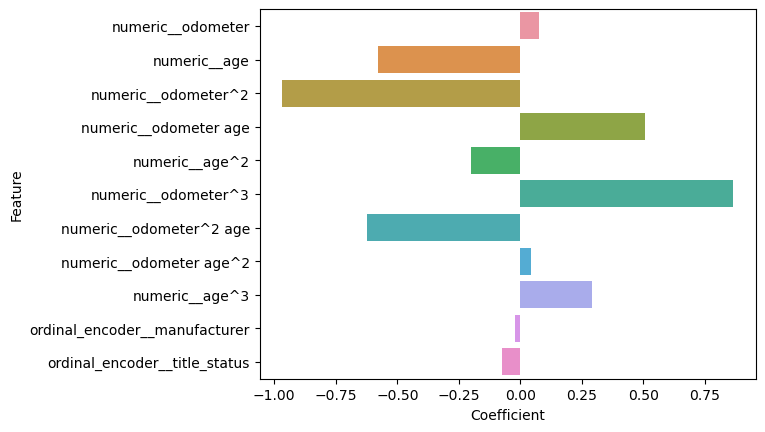

In [44]:
sns.barplot(data = coef_df, x = 'Coefficient', y = 'Feature').get_figure().savefig('images/coef-lin-reg.png')

In [45]:
feature_names = sfs_lasso_pipeline[:-1].get_feature_names_out()
coefficients = sfs_lasso_pipeline.named_steps['lin_regression'].coef_
coef_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})
coef_df

,Feature,Coefficient
0,numeric__odometer,-0.213377
1,numeric__age,-0.462055
2,numeric__odometer^2,-0.036292
3,numeric__odometer age,0.076101


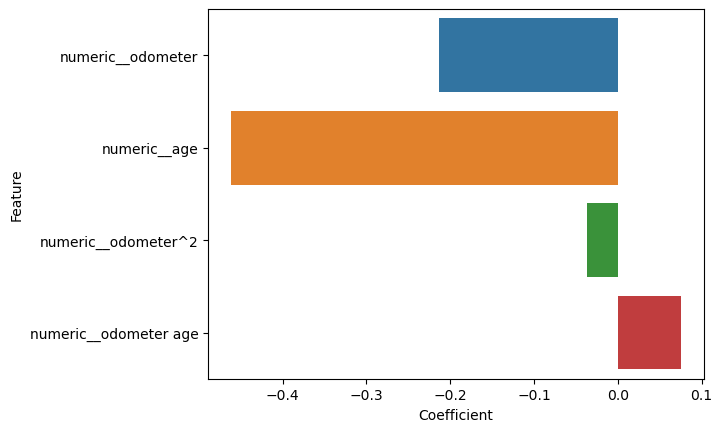

In [46]:
sns.barplot(data = coef_df, x = 'Coefficient', y = 'Feature').get_figure().savefig('images/coef-sfs.png')

As you can see odometer rating and age (year of manufacture) of a vehicle plays crucial role in sales price of a vehicle. Title status or brand name have little influence on the price contrary to what I initially thought.

We should go back and try to include other categorical features that were intentionally removed from the data set due to large amount of missing values.

### Deployment

Now that we've settled on our models and findings, it is time to deliver the information to the client.  You should organize your work as a basic report that details your primary findings.  Keep in mind that your audience is a group of used car dealers interested in fine tuning their inventory.

📌 Report to Shareholders

Given the data and predictive machine model trained on that data we identified key drivers on car sale price.

Contrary to popular believe, condition, title status or even brand name does not matter much in sale price negotiations. Vehicle age and mileage are the key factors driving the price. The customers do not pay attention to superficial properties. Regardless if they are frugal or in a pinch, their budget certainly excludes dream for a new car. Pre-owned car buyers look for the best bang for their buck. Car's age and low mileage is what they are after.

To increase sales we suggest you look to stock vehicles with lowest mileage possible and a few years old at the most.